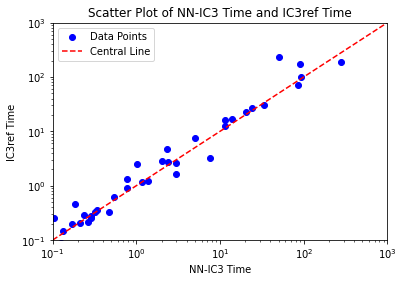

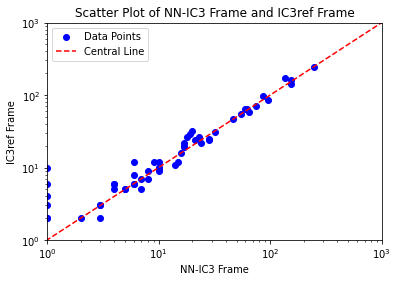

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

log_file = "compare_with_ic3ref_hwmcc2007.csv"

# Set display options to avoid truncation
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("max_colwidth", None)
pd.set_option("display.max_rows", None)

# read csv table from log/compare_with_ic3ref.csv
df = pd.read_csv(f"log/{log_file}")

# Strip out the spaces from column names
df.columns = df.columns.str.strip()

# Filter and sort dataframe
if "ic3ref" in log_file:
    df = df[(df["NN-IC3-bg"] == 1) & (df["IC3ref-bg"] == 1) | (df["NN-IC3-bg"] == 0) & (df["IC3ref-bg"] == 0)]
    df = df.sort_values(by=["case name", "NN-IC3 Time"])
    df.drop_duplicates(subset="case name", keep="first", inplace=True)
    df = df.reset_index(drop=True)

# Time scatter plot
plt.scatter(df["NN-IC3 Time"], df["IC3ref Time"], color="blue", label="Data Points")
plt.xlabel("NN-IC3 Time")
plt.ylabel("IC3ref Time")
plt.title("Scatter Plot of NN-IC3 Time and IC3ref Time")

# Apply the log scale
plt.xscale("log")
plt.yscale("log")

# Set the axis limits
plt.xlim(0.1, 1000)
plt.ylim(0.1, 1000)

# Diagonal line values
diag_min = 0.1
diag_max = 1000

# Plot the diagonal line
plt.plot([diag_min, diag_max], [diag_min, diag_max], color="red", linestyle="--", label="Central Line")
plt.legend()
plt.show()

# Frame scatter plot
plt.scatter(df["NN-IC3 Frame"], df["IC3ref Frame"], color="blue", label="Data Points")
plt.xlabel("NN-IC3 Frame")
plt.ylabel("IC3ref Frame")
plt.title("Scatter Plot of NN-IC3 Frame and IC3ref Frame")

# Apply the log scale
plt.xscale("log")
plt.yscale("log")

# Set the axis limits
plt.xlim(1, 1000)
plt.ylim(1, 1000)

# Plot the diagonal line
plt.plot([diag_min, diag_max], [diag_min, diag_max], color="red", linestyle="--", label="Central Line")
plt.legend()
plt.show()


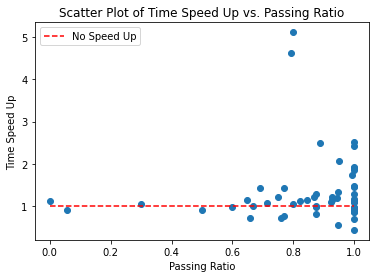

In [84]:
import os

def read_clauses(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if not line.startswith('unsat')]
        clauses = [set(map(int, line.split())) for line in lines]
    return clauses

def coverage_ratio(inv_cti_clauses, predicted_clauses):
    # inv_cti_clauses: list of clauses that predicted before filtering
    # predicted_clauses: list of clauses that predicted after filtering
    
    found_clauses = 0
    total_clauses = len(inv_cti_clauses)

    if total_clauses == 0:
        return 0

    for inv_cti_clause in inv_cti_clauses:
        inv_cti_clause_sorted = sorted(inv_cti_clause)
        for predicted_clause in predicted_clauses:
            if inv_cti_clause_sorted == sorted(predicted_clause):
                found_clauses += 1
                break
    
    # equation: (amount of found clauses that converged) / (total amount of clauses)
    return found_clauses / total_clauses

base_path = "/data/guangyuh/coding_env/AIG2INV/AIG2INV_main/case4comp/dataset_hwmcc2007_tip_ic3ref_no_simplification_0-22_comp/"
cases = os.listdir(base_path)

results = []

for case in cases:
    inv_cti_path = os.path.join(base_path, case, f"{case}_inv_CTI_predicted.cnf")
    predicted_path = os.path.join(base_path, case, f"{case}_predicted_clauses_after_filtering.cnf")

    inv_cti_clauses = read_clauses(inv_cti_path)
    predicted_clauses = read_clauses(predicted_path)

    ratio = coverage_ratio(inv_cti_clauses, predicted_clauses)
    results.append({"case": case, "coverage_ratio": ratio})

results_df = pd.DataFrame(results)

# Existing DataFrame
existing_df = df

# Merge DataFrames on the 'case' column
merged_df = existing_df.merge(results_df, left_on='case name', right_on='case')

# Drop the 'case' column as it's redundant
merged_df.drop(columns=['case'], inplace=True)

# Rename the 'coverage_ratio' column if necessary
merged_df.rename(columns={'coverage_ratio': 'passing ratio'}, inplace=True)

# Calculate the time speed up and add it to the DataFrame
merged_df['time speed up'] = merged_df['IC3ref Time'] / merged_df['NN-IC3 Time']

# Scatter plot
plt.scatter(merged_df['passing ratio'], merged_df['time speed up'])
plt.xlabel('Passing Ratio')
plt.ylabel('Time Speed Up')
plt.title('Scatter Plot of Time Speed Up vs. Passing Ratio')
# No speed up line
x = [0, max(merged_df['passing ratio'])]
y = [1, 1]
plt.plot(x, y, label='No Speed Up', linestyle='--', color='red')

plt.legend()
plt.show()

plt.show()

#print(merged_df)


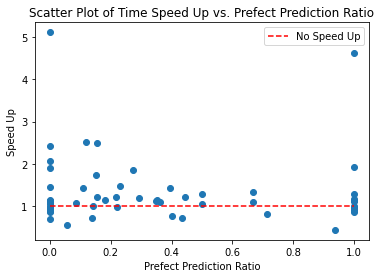

In [85]:
import os

def read_clauses(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if not line.startswith('unsat')]
        clauses = [set(map(int, line.split())) for line in lines]
    return clauses

def coverage_ratio(inv_cti_clauses, ground_truth_clauses):
    # inv_cti_clauses: list of clauses that predicted before filtering
    # ground_truth_clauses: list of clauses that predicted after filtering
    
    found_clauses = 0
    total_clauses = len(inv_cti_clauses)

    if total_clauses == 0:
        return 0

    for inv_cti_clause in inv_cti_clauses:
        inv_cti_clause_sorted = sorted(inv_cti_clause)
        for gt_clause in ground_truth_clauses:
            if inv_cti_clause_sorted == sorted(gt_clause):
                found_clauses += 1
                break

    # equation: (amount of found clauses that converged) / (total amount of clauses)
    return found_clauses / total_clauses


base_path = "/data/guangyuh/coding_env/AIG2INV/AIG2INV_main/case4comp/dataset_hwmcc2007_tip_ic3ref_no_simplification_0-22_comp/"
ground_truth_base_path = "/data/guangyuh/coding_env/AIG2INV/AIG2INV_main/ground_truth/hwmcc07-ic3ref_7200-result"
cases = os.listdir(base_path)

results = []

for case in cases:
    ground_truth_path  = os.path.join(ground_truth_base_path, case, "inv.cnf")
    inv_cti_path  = os.path.join(base_path, case, f"{case}_predicted_clauses_after_filtering.cnf")

    inv_cti_clauses = read_clauses(inv_cti_path)
    ground_truth_clauses = read_clauses(ground_truth_path)

    ratio = coverage_ratio(inv_cti_clauses, ground_truth_clauses)
    results.append({"case": case, "coverage_ratio": ratio})

results_df = pd.DataFrame(results)

# Existing DataFrame
existing_df = df

# Merge DataFrames on the 'case' column
merged_df = existing_df.merge(results_df, left_on='case name', right_on='case')

# Drop the 'case' column as it's redundant
merged_df.drop(columns=['case'], inplace=True)

# Rename the 'coverage_ratio' column if necessary
merged_df.rename(columns={'coverage_ratio': 'prefect prediction ratio'}, inplace=True)

# Calculate the time speed up and add it to the DataFrame
merged_df['time speed up'] = merged_df['IC3ref Time'] / merged_df['NN-IC3 Time']

# Scatter plot
plt.scatter(merged_df['prefect prediction ratio'], merged_df['time speed up'])
plt.xlabel('Prefect Prediction Ratio')
plt.ylabel('Speed Up')
plt.title('Scatter Plot of Time Speed Up vs. Prefect Prediction Ratio')
# No speed up line
x = [0, max(merged_df['prefect prediction ratio'])]
y = [1, 1]
plt.plot(x, y, label='No Speed Up', linestyle='--', color='red')

plt.legend()
plt.show()

plt.show()

#print(merged_df)


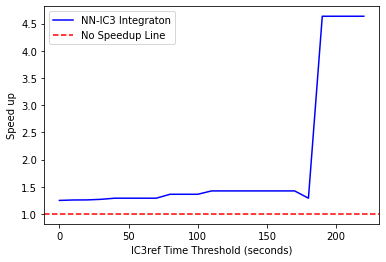

In [86]:
import numpy as np

def calculate_speedup_factor(df, x):
    # Filter cases where IC3ref Time is greater than x seconds
    df_filtered = df[ (df["IC3ref Time"] > x) & (df["IC3ref Time"] < 10000)]
    #df_filtered = df[df["IC3ref Time"] > x]
    # Calculate the accumulated time for IC3ref and NN-IC3
    accumulated_ic3ref_time = df_filtered["IC3ref Time"].sum()
    accumulated_nn_ic3_time = df_filtered["NN-IC3 Time"].sum()

    # Calculate the speedup factor for the accumulated times
    #print(f"accumulated_ic3ref_time is {accumulated_ic3ref_time}, accumulated_nn_ic3_time is {accumulated_nn_ic3_time}")
    speedup_factor = accumulated_ic3ref_time / accumulated_nn_ic3_time

    return speedup_factor

# Define the range of x values (thresholds)
x_values = np.arange(0, 230, 10)

# Calculate the speedup factor for each x value
speedup_factors = [calculate_speedup_factor(df, x) for x in x_values]

# Create the plot
plt.plot(x_values, speedup_factors, color="blue", label="NN-IC3 Integraton")
plt.xlabel("IC3ref Time Threshold (seconds)")
plt.ylabel("Speed up")
#plt.title("Speedup Factor by IC3ref Time Threshold")
plt.axhline(y=1, color="red", linestyle="--", label="No Speedup Line")
plt.legend()
plt.show()


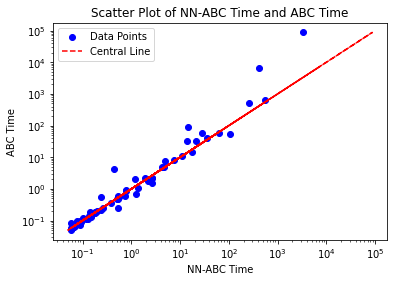

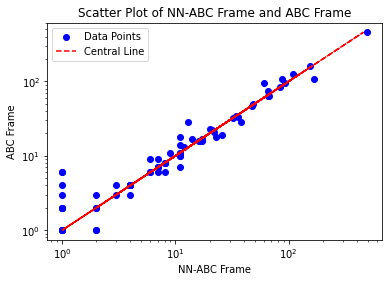

In [87]:
import fileinput
import pandas as pd
import matplotlib.pyplot as plt

log_file = "compare_with_abc_hwmcc2007.csv"

# Set display options to avoid truncation
pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("max_colwidth", None)
pd.set_option("display.max_rows", None)

# read csv table from log/compare_with_ic3ref.csv
df = pd.read_csv(f"log/{log_file}")

# Strip out the spaces from column names
df.columns = df.columns.str.strip()

# Filter and sort dataframe
if "abc" in log_file:
    #df = df[(df["NN-IC3-bg"] == 1) & (df["IC3ref-bg"] == 1) | (df["NN-IC3-bg"] == 0) & (df["IC3ref-bg"] == 0)]
    df = df.sort_values(by=["case name", "NN-ABC Time"])
    df.drop_duplicates(subset="case name", keep="first", inplace=True)
    df = df.reset_index(drop=True)

# Create scatter plot for time
plt.scatter(df["NN-ABC Time"], df["ABC Time"], color="blue", label="Data Points")
plt.xlabel("NN-ABC Time")
plt.ylabel("ABC Time")
plt.title("Scatter Plot of NN-ABC Time and ABC Time")
plt.plot(df["ABC Time"], df["ABC Time"], color="red", linestyle="--", label="Central Line")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# Create scatter plot for frames
plt.scatter(df["NN-ABC Frame"], df["ABC Frame"], color="blue", label="Data Points")
plt.xlabel("NN-ABC Frame")
plt.ylabel("ABC Frame")
plt.title("Scatter Plot of NN-ABC Frame and ABC Frame")
plt.plot(df["ABC Frame"], df["ABC Frame"], color="red", linestyle="--", label="Central Line")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()


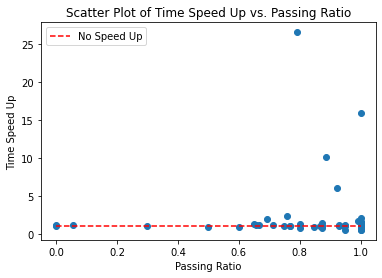

In [88]:
import os

def read_clauses(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if not line.startswith('unsat')]
        clauses = [set(map(int, line.split())) for line in lines]
    return clauses

def coverage_ratio(inv_cti_clauses, predicted_clauses):
    # inv_cti_clauses: list of clauses that predicted before filtering
    # predicted_clauses: list of clauses that predicted after filtering
    
    found_clauses = 0
    total_clauses = len(inv_cti_clauses)

    if total_clauses == 0:
        return 0

    for inv_cti_clause in inv_cti_clauses:
        inv_cti_clause_sorted = sorted(inv_cti_clause)
        for predicted_clause in predicted_clauses:
            if inv_cti_clause_sorted == sorted(predicted_clause):
                found_clauses += 1
                break
    
    # equation: (amount of found clauses that converged) / (total amount of clauses)
    return found_clauses / total_clauses

base_path = "/data/guangyuh/coding_env/AIG2INV/AIG2INV_main/case4comp/dataset_hwmcc2007_tip_abc_no_simplification_0-22_comp/"
cases = os.listdir(base_path)

results = []

for case in cases:
    inv_cti_path = os.path.join(base_path, case, f"{case}_inv_CTI_predicted.cnf")
    predicted_path = os.path.join(base_path, case, f"{case}_predicted_clauses_after_filtering.cnf")

    inv_cti_clauses = read_clauses(inv_cti_path)
    predicted_clauses = read_clauses(predicted_path)

    ratio = coverage_ratio(inv_cti_clauses, predicted_clauses)
    results.append({"case": case, "coverage_ratio": ratio})

results_df = pd.DataFrame(results)

# Existing DataFrame
existing_df = df

# Merge DataFrames on the 'case' column
merged_df = existing_df.merge(results_df, left_on='case name', right_on='case')

# Drop the 'case' column as it's redundant
merged_df.drop(columns=['case'], inplace=True)

# Rename the 'coverage_ratio' column if necessary
merged_df.rename(columns={'coverage_ratio': 'passing ratio'}, inplace=True)

# Calculate the time speed up and add it to the DataFrame
merged_df['time speed up'] = merged_df['ABC Time'] / merged_df['NN-ABC Time']

# Scatter plot
plt.scatter(merged_df['passing ratio'], merged_df['time speed up'])
plt.xlabel('Passing Ratio')
plt.ylabel('Time Speed Up')
plt.title('Scatter Plot of Time Speed Up vs. Passing Ratio')
# No speed up line
x = [0, max(merged_df['passing ratio'])]
y = [1, 1]
plt.plot(x, y, label='No Speed Up', linestyle='--', color='red')

plt.legend()
plt.show()

plt.show()

#print(merged_df)


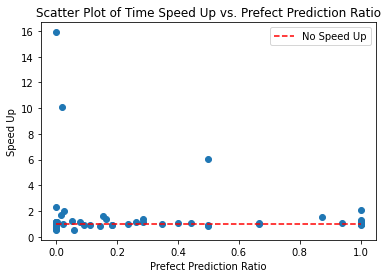

In [89]:
import os

def read_clauses(file_path):
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines() if not line.startswith('unsat')]
        clauses = [set(map(int, line.split())) for line in lines]
    return clauses

def coverage_ratio(inv_cti_clauses, ground_truth_clauses):
    # inv_cti_clauses: list of clauses that predicted before filtering
    # ground_truth_clauses: list of clauses that predicted after filtering
    
    found_clauses = 0
    total_clauses = len(inv_cti_clauses)

    if total_clauses == 0:
        return 0

    for inv_cti_clause in inv_cti_clauses:
        inv_cti_clause_sorted = sorted(inv_cti_clause)
        for gt_clause in ground_truth_clauses:
            if inv_cti_clause_sorted == sorted(gt_clause):
                found_clauses += 1
                break

    # equation: (amount of found clauses that converged) / (total amount of clauses)
    return found_clauses / total_clauses


base_path = "/data/guangyuh/coding_env/AIG2INV/AIG2INV_main/case4comp/dataset_hwmcc2007_tip_abc_no_simplification_0-22_comp/"
ground_truth_base_path = "/data/guangyuh/coding_env/AIG2INV/AIG2INV_main/ground_truth/hwmcc07_abc_7200_result"
cases = os.listdir(base_path)

results = []

for case in cases:
    # if file not exist, skip
    if not os.path.exists(os.path.join(ground_truth_base_path, case, "inv.cnf")):
        continue
    ground_truth_path  = os.path.join(ground_truth_base_path, case, "inv.cnf")
    inv_cti_path  = os.path.join(base_path, case, f"{case}_predicted_clauses_after_filtering.cnf")

    inv_cti_clauses = read_clauses(inv_cti_path)
    ground_truth_clauses = read_clauses(ground_truth_path)

    ratio = coverage_ratio(inv_cti_clauses, ground_truth_clauses)
    results.append({"case": case, "coverage_ratio": ratio})

results_df = pd.DataFrame(results)

# Existing DataFrame
existing_df = df

# Merge DataFrames on the 'case' column
merged_df = existing_df.merge(results_df, left_on='case name', right_on='case')

# Drop the 'case' column as it's redundant
merged_df.drop(columns=['case'], inplace=True)

# Rename the 'coverage_ratio' column if necessary
merged_df.rename(columns={'coverage_ratio': 'prefect prediction ratio'}, inplace=True)

# Calculate the time speed up and add it to the DataFrame
merged_df['time speed up'] = merged_df['ABC Time'] / merged_df['NN-ABC Time']

# Scatter plot
plt.scatter(merged_df['prefect prediction ratio'], merged_df['time speed up'])
plt.xlabel('Prefect Prediction Ratio')
plt.ylabel('Speed Up')
plt.title('Scatter Plot of Time Speed Up vs. Prefect Prediction Ratio')
# No speed up line
x = [0, max(merged_df['prefect prediction ratio'])]
y = [1, 1]
plt.plot(x, y, label='No Speed Up', linestyle='--', color='red')

plt.legend()
plt.show()

plt.show()

#print(merged_df)


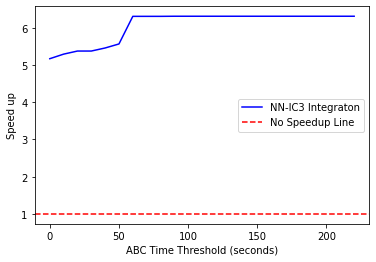

In [90]:
import numpy as np

def calculate_speedup_factor(df, x):
    # Filter cases where IC3ref Time is greater than x seconds
    df_filtered = df[ (df["ABC Time"] > x) & (df["ABC Time"] < 10000) ]
    #df_filtered = df[ df["ABC Time"]> x ]
    # Calculate the accumulated time for IC3ref and NN-IC3
    accumulated_ic3_abc_time = df_filtered["ABC Time"].sum()
    accumulated_nn_ic3_time = df_filtered["NN-ABC Time"].sum()

    # Calculate the speedup factor for the accumulated times
    speedup_factor = accumulated_ic3_abc_time / accumulated_nn_ic3_time

    return speedup_factor

# Define the range of x values (thresholds)
x_values = np.arange(0, 230, 10)
#x_values = np.arange(0, 1000, 10)
#x_values = np.arange(0, 3500, 10)

# Calculate the speedup factor for each x value
speedup_factors = [calculate_speedup_factor(df, x) for x in x_values]

# Create the plot
plt.plot(x_values, speedup_factors, color="blue", label="NN-IC3 Integraton")
plt.xlabel("ABC Time Threshold (seconds)")
plt.ylabel("Speed up")
#plt.title("Speedup Factor by ABC Time Threshold")
plt.axhline(y=1, color="red", linestyle="--", label="No Speedup Line")
plt.legend()
plt.show()
